In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


**Work Flow**

**1, brief introdcution of CNN**

this is a 5 layers sequential convolutional neural network for digit recognition trained on MNIST dataset

**2, Data preparation**

load data
check for null and missing values
normalization
reshape
label encoding
split training and validation set**

**3, CNN**

define the model
set the optimizer and annealer
data augmentation**

**4, Evaluate the model**

training and validation curves
confusion matrix**

**5, prediction and submition**
predict and submit result







In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mping
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

In [3]:
# Load the data

train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

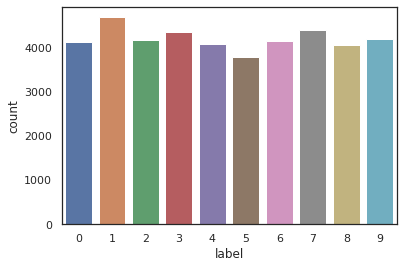

In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [5]:
# check the data

X_train.isnull().any().describe

<bound method NDFrame.describe of pixel0      False
pixel1      False
pixel2      False
pixel3      False
pixel4      False
            ...  
pixel779    False
pixel780    False
pixel781    False
pixel782    False
pixel783    False
Length: 784, dtype: bool>

In [6]:
test.isnull().any().describe

<bound method NDFrame.describe of pixel0      False
pixel1      False
pixel2      False
pixel3      False
pixel4      False
            ...  
pixel779    False
pixel780    False
pixel781    False
pixel782    False
pixel783    False
Length: 784, dtype: bool>

we do not have any misssing values and null in our training and test dataset.

In [7]:
# normalize the data
# standardazing the pixel value form zero to one
X_train = X_train/255.0
test = test/255.0

In [8]:
# reshape the data
# train and test images (28x28) in panda dataframe tranfromed as 1d vector 
# of 784 values, we reshape all data to 28x28x1 matrices # 1 is for channels
# if we had colorized image, the channels will be 3, in our case, we have gray image.

X_train = X_train.values.reshape(-1,28,28,1)

test = test.values.reshape(-1,28,28,1)




In [9]:
# label encoding
# encode labels to one hot vector
# ex, 3 -> 0,0,0,0,1,0,0,0,0,0

Y_tarin = to_categorical(Y_train, num_classes = 10)


In [10]:
# split training and validation set

random_seed = 2

# split the train and the validaiton set for the fitting

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

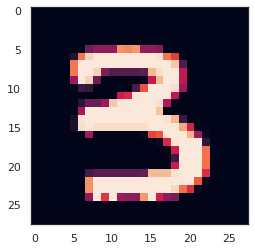

In [11]:
# visualising the image and looking and the label
# some examples 
# you can change 16 to show other numbers, and last 0 means index.

g = plt.imshow(X_train[16][:,:,0])

**define the model**

the keras sequencial API was used

the first layer is convolutional layer(Conv2D)
32 filters were setted to two fisrt layers and 64 filter for last two one. filter is a matrix for transforming images

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost,

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.



In [12]:
# CNN archituecture
# (Conv2D->relu)*2 ->(MaxPool2D -> Dropout)*2 -> Flatten ->Dense -> Dropout ->out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [13]:
# set the optimizer
# I used RMSprop, we could use Stochastic gradient decent but its slow

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [14]:
#compile the model
model.compile(optimizer = optimizer, loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

**The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.**

**Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.**

**To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).**

**With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.**

In [15]:
# set a learning rate amnealer
#

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [16]:
epochs = 5
batch_size = 86

In [17]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [18]:
# fit the model 
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

2022-01-15 17:26:18.551327: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
439/439 - 88s - loss: 0.4027 - accuracy: 0.8721 - val_loss: 0.0845 - val_accuracy: 0.9714
Epoch 2/5
439/439 - 86s - loss: 0.1242 - accuracy: 0.9626 - val_loss: 0.0436 - val_accuracy: 0.9874
Epoch 3/5
439/439 - 85s - loss: 0.0915 - accuracy: 0.9729 - val_loss: 0.0354 - val_accuracy: 0.9888
Epoch 4/5
439/439 - 86s - loss: 0.0799 - accuracy: 0.9766 - val_loss: 0.0301 - val_accuracy: 0.9900
Epoch 5/5
439/439 - 85s - loss: 0.0688 - accuracy: 0.9805 - val_loss: 0.0355 - val_accuracy: 0.9902


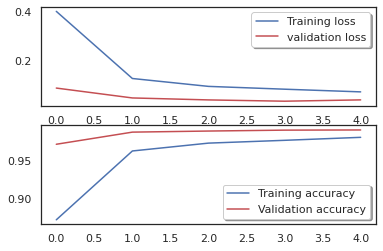

In [19]:
# plot the loss and accuracy curves for training and validation

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

In [21]:
# Predict the values from the validation dataset
#Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
#Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
#Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
#confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
#plot_confusion_matrix(confusion_mtx, classes = range(10))

In [22]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


In [23]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)